## Import libraries and read data

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.ML.Cluster import Butina

In [18]:
HERE = Path(_dh[-1])
FOLDER = HERE.parent.parent/'data/fragments'

fda_ring_fragments = pd.read_csv(FOLDER/'unique/drug_fragments_no_duplicated.csv')
fda_ring_fragments

,parent_smiles,ring_fragment,chembl_id
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308
1,C1CNCCN1,C1CNCCN1,CHEMBL1412
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O,CHEMBL771
4,Nc1ccncc1N,Nc1ccncc1N,CHEMBL354077
...,...,...,...
3585,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,CC1NC(=O)C(N)CCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C)N...,CHEMBL1201441
3586,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@@H]1O[C@@H](O)C[C@](C)(N)[C@@H]1O,CHEMBL507870
3587,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,CHEMBL507870
3588,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,Cc1c(O)cc2c(c1O)-c1cc(ccc1O)[C@H]1NC(=O)[C@@H]...,CHEMBL507870


In [19]:
## rdkit.Chem.Mol object from SMILES and store it into a list
compounds = []

for _,ring_fragment, chembl_id in fda_ring_fragments[['ring_fragment', 'chembl_id']].itertuples():
    compounds.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

print(f'Number of compounds successfully inserted into list: {len(compounds)}')
compounds[0:5]

Number of compounds successfully inserted into list: 3590


[(<rdkit.Chem.rdchem.Mol at 0x7f057b5b9a00>, 'CHEMBL1308'),
 (<rdkit.Chem.rdchem.Mol at 0x7f057b5b92e0>, 'CHEMBL1412'),
 (<rdkit.Chem.rdchem.Mol at 0x7f057b5b9940>, 'CHEMBL284348'),
 (<rdkit.Chem.rdchem.Mol at 0x7f057b5b9760>, 'CHEMBL771'),
 (<rdkit.Chem.rdchem.Mol at 0x7f057b5b9520>, 'CHEMBL354077')]

## Compute fingerprints, tanimoto similarity and distance matrix

### 1) Compute fingerprints

In [20]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in compounds]

print(f'Number of compounds converted: {len(fingerprints)} \
    Figerprint length per compound: {len(fingerprints[0])}')

Number of compounds converted: 3590     Figerprint length per compound: 2048


### 2) Tanimoto similarity and distance matrix

In [21]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    """
    """
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    
    return dissimilarity_matrix

In [22]:
n = len(fingerprints)
elem_triangular_matr =  ((n*(n-1))/2)
print(
    f'Elements in the triangular matrix: {elem_triangular_matr} ==',
    f'tanimoto_distance_matrix(fingerprints): \n{len(tanimoto_distance_matrix(fingerprints))}'
)

Elements in the triangular matrix: 6442255.0 == tanimoto_distance_matrix(fingerprints): 
6442255


### 3) Clustering process, select threshold

In [23]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """
    Clusterization based on fingerprints
    Parameters:
    fingerprints (list of fingerprints calculated)
    """
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Calculate Tanimoto distance matrix
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

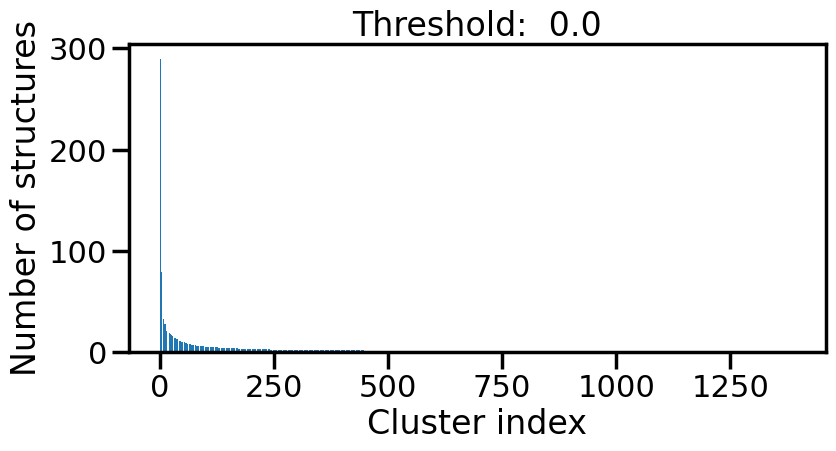

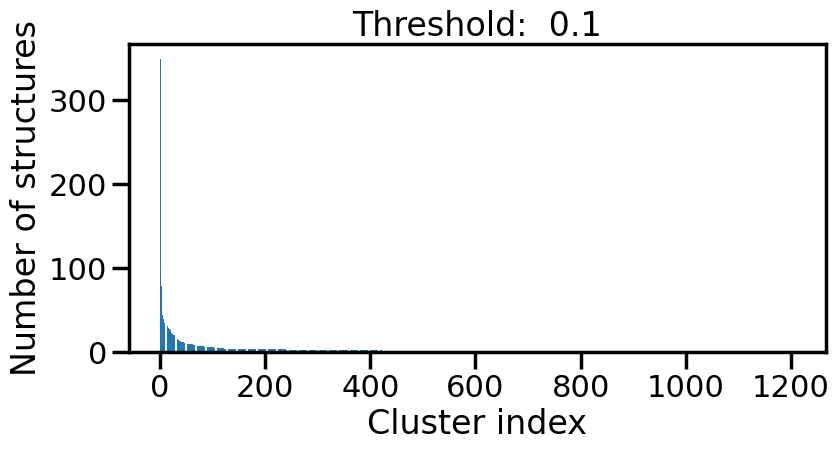

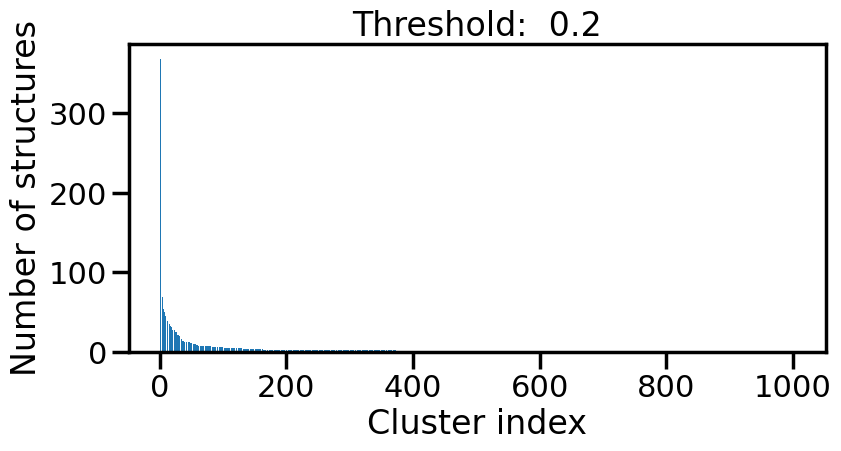

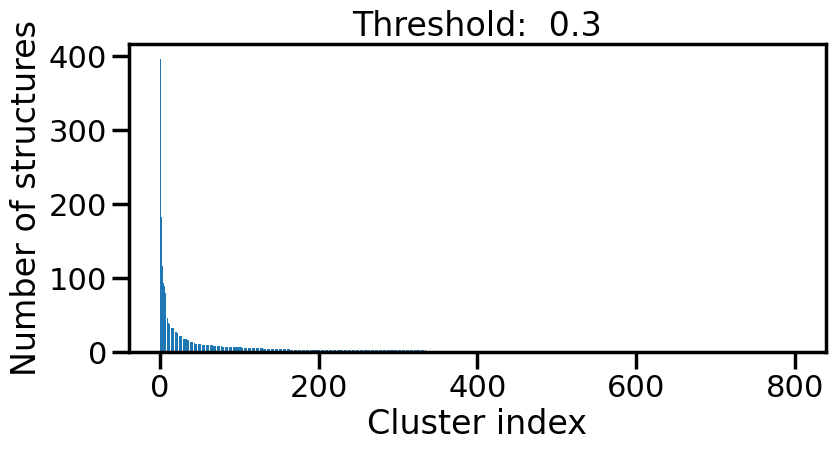

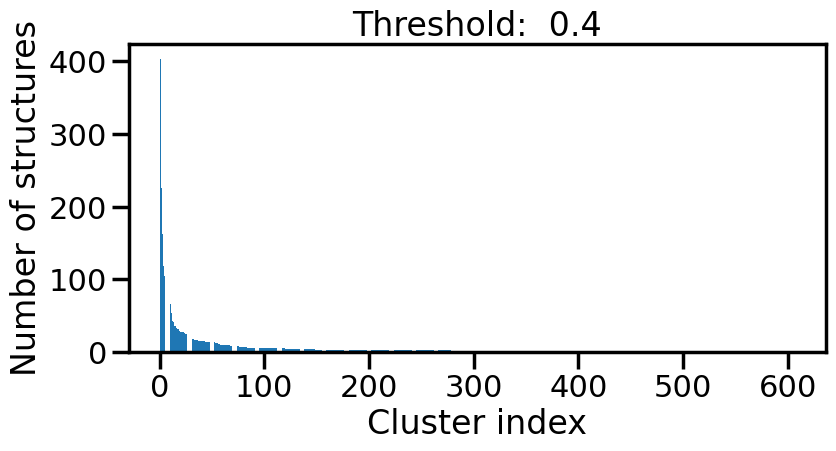

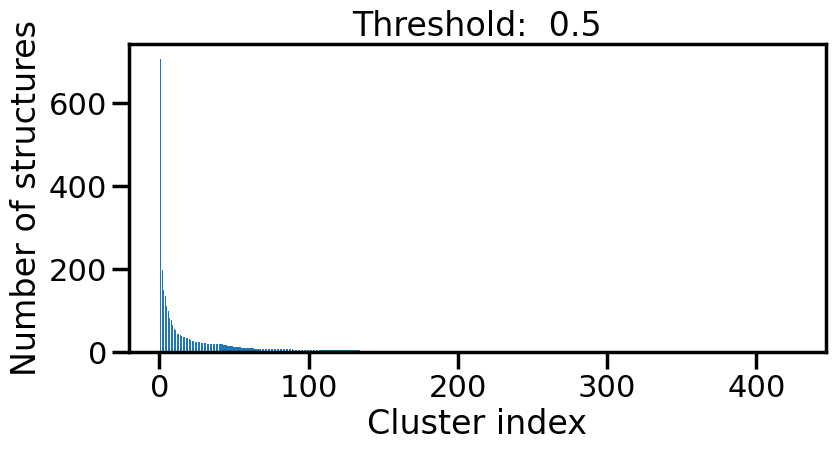

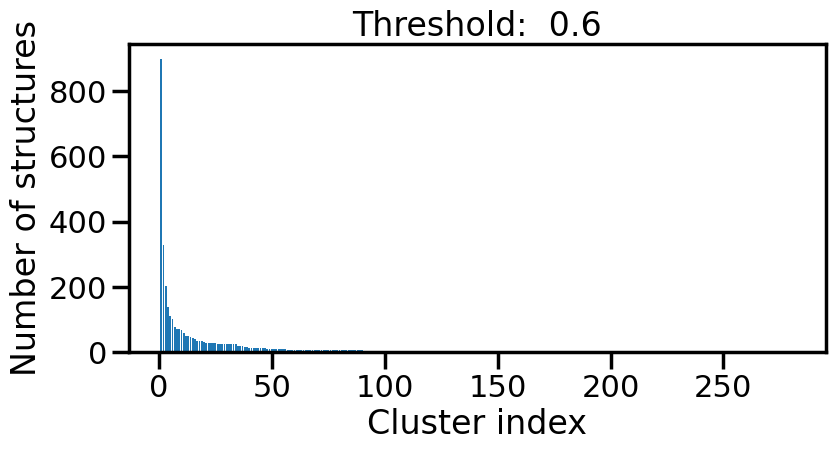

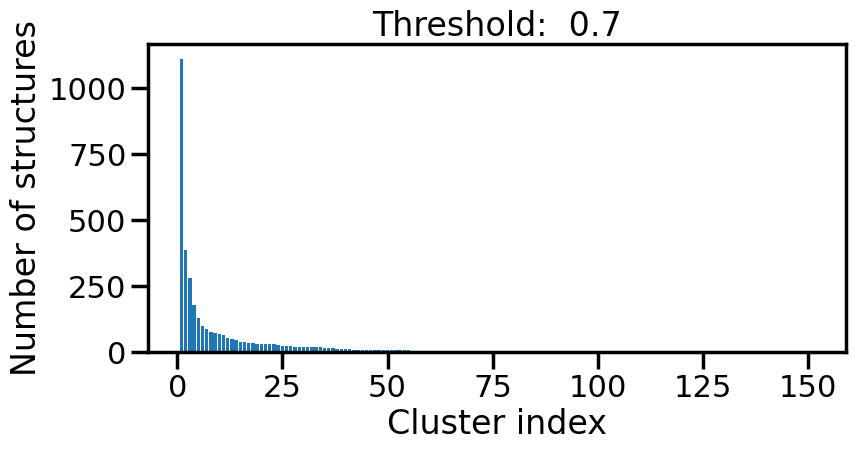

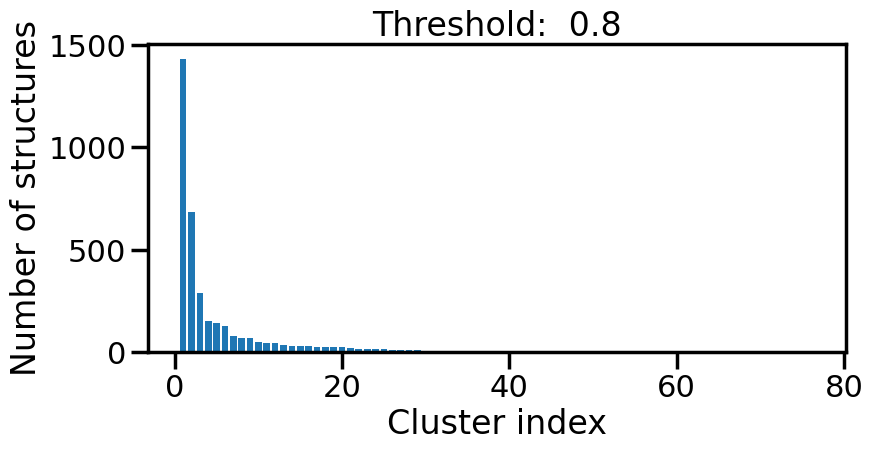

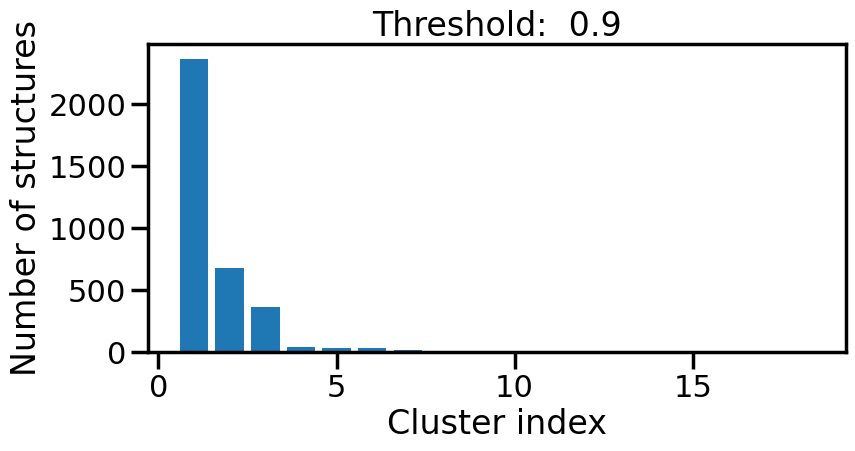

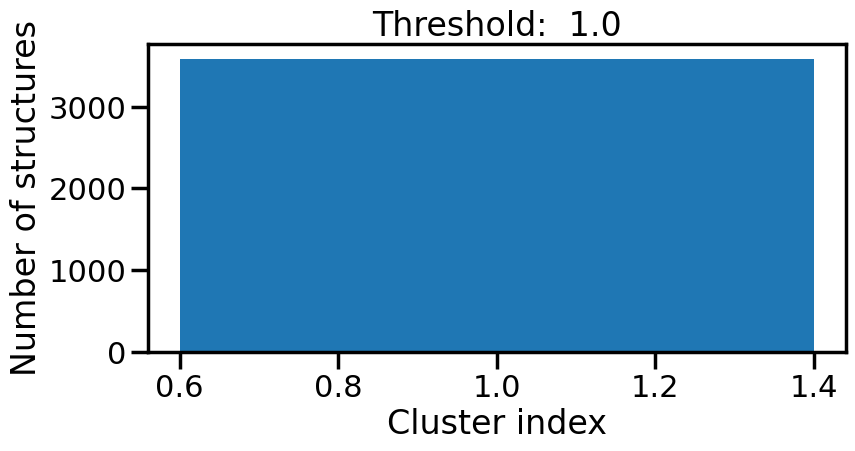

In [24]:
sns.set_context('poster')
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

I liked the option where the dissimilarity threshold is 0.2, let's see how this goes.

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.2')

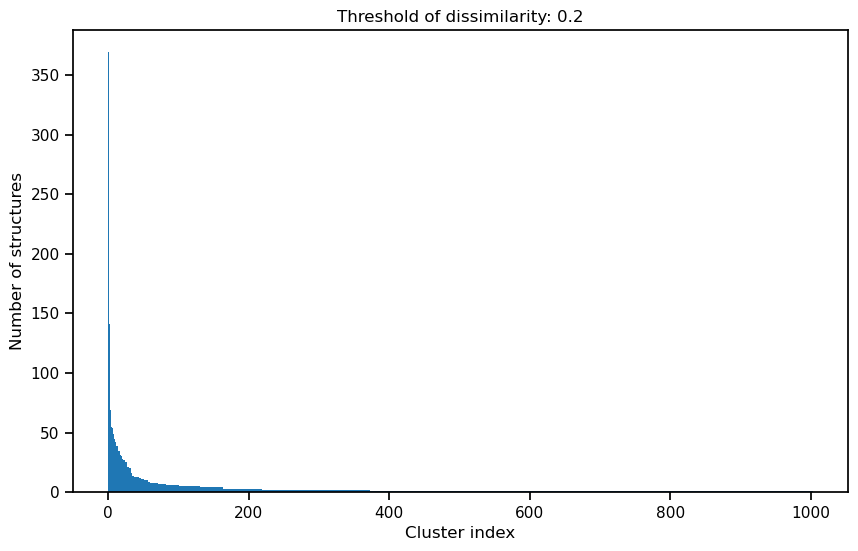

In [37]:
sns.set_context('notebook')
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], width=1.2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [38]:
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} ring fragments",
    f"\n Number of RF in the first 10 clusters: {sum([len(clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 clusters: {sum([len(clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 100 clusters: {sum([len(clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 1002 from 3590 ring fragments 
 Number of RF in the first 10 clusters: 966 
 Number of RF in the first 20 clusters: 1315 
 Number of RF in the first 100 clusters: 2202 


## Basic Visualization

/home/gustavos/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


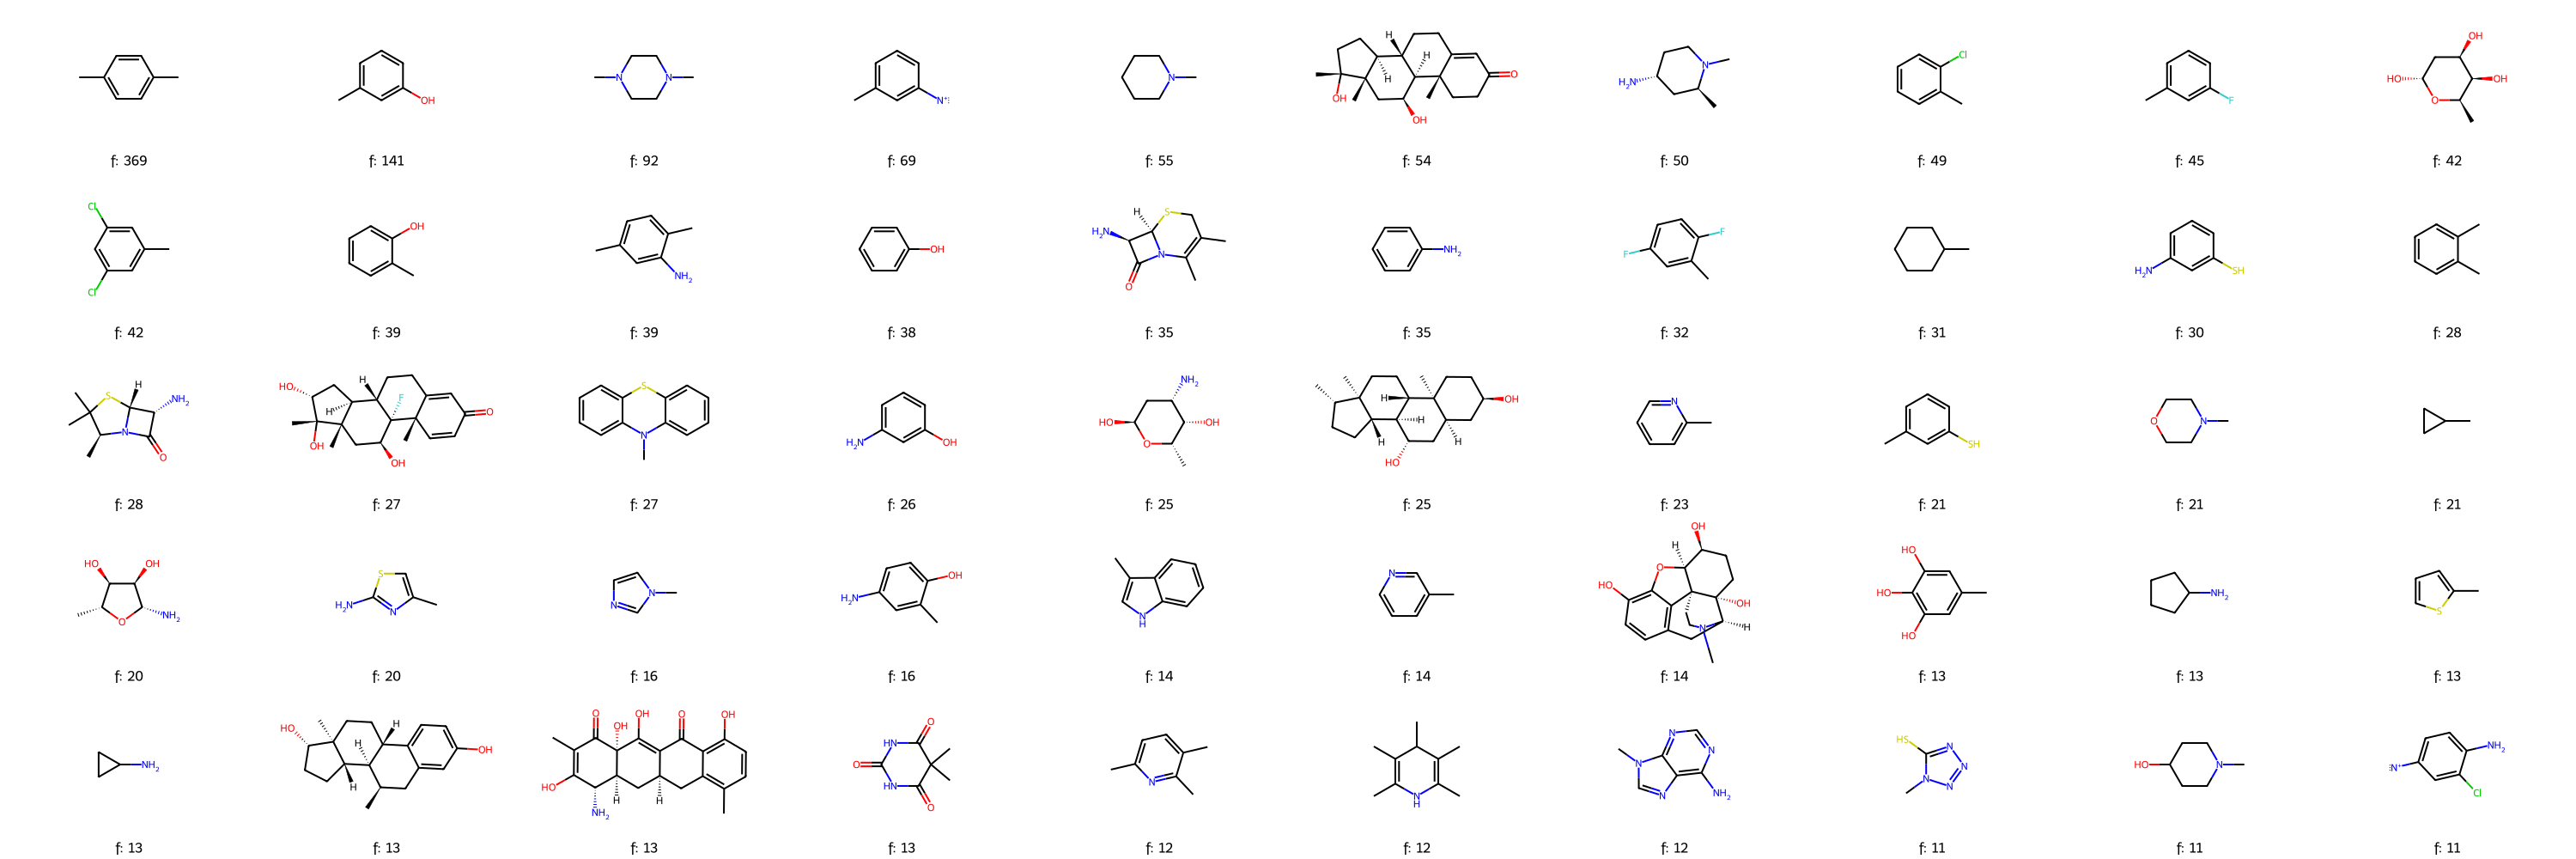

In [57]:
def draw_top_n_centroids(n, clusters, compounds, molsPerRow):
    centroids = [cluster[0] for cluster in clusters[0:n]]
    mols = [compounds[c][0] for c in centroids]
   
    return Draw.MolsToGridImage(
        mols,
        legends= [f'f: {len(c)}' for c in clusters[0:n]],
        molsPerRow=molsPerRow,
        subImgSize=(300,200),
        maxMols=50
    )
draw_top_n_centroids(100, clusters, compounds, molsPerRow=10)